# Notebook for working with root files from DDSIM to look at hcalbarrelhits and MCParticles

In [1]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm


Open the root file with up.open, then save a branch to a np array using the .array() method

In [2]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/variation/full_{particle}_{energy}GeV_10k.edm4hep.root:events"
events = up.open(uproot_path)

x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
MC_parents = events["_MCParticles_parents.index"].array(library='np')
MC_daughters = events["MCParticles.daughters_end"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
MC_endpoint_x_branch = events["MCParticles.endpoint.x"].array(library='np')
layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

This function gets the layer index from the position - the layer map is a list of the midpoints of each layer, and each layer is 1cm thick, so we can 
check if hits hit within 0.5cm on each side of the midpoint to check which layer they hit

In [3]:
def get_num_layers_traversed(x_pos):
    #This map contains the midpoints of each layer - each layer is 1cm in width, so we can check the 0.5cm on each side to see if a hit was in the layer
    layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]
    for layer_idx in range(len(layer_map)):
        #check if particle hit within layer
        if ((x_pos >= layer_map[layer_idx] - 5) and (x_pos <= layer_map[layer_idx] + 5)):
            return layer_idx
    #if no layers hit, send error code
    return -1

## Percentage of photons hitting sensor

In [6]:
MC_px = events["MCParticles.momentum.x"].array(library='np')
MC_py = events["MCParticles.momentum.y"].array(library='np')
MC_pz = events["MCParticles.momentum.z"].array(library='np')
MC_m = events["MCParticles.mass"].array(library='np')

In [7]:
#theta = 0: px, py = 0
#theta - xz plane
#phi - xy plane
def theta_func(px,py,pz):
    return np.arctan(px/pz) / np.pi * 180
def phi_func(px,py,pz):
    return np.arctan(py/px) / np.pi * 180
def Efunc(px,py,pz,m):
    return np.sqrt(px**2 + py**2 + pz**2 + m**2)
    
class PVect:
    def __init__(self):
        self.px = 0
        self.py = 0
        self.pz = 0
        self.theta = 0
        self.phi = 0
        self.E = 0
        self.M = 0
    def setVector(self,px,py,pz,m):
        self.px = px
        self.py = py
        self.pz = pz
        self.M = m
        self.E = Efunc(px,py,pz,m)
        self.theta = theta_func(px,py,pz)
        self.phi = phi_func(px,py,pz)

In [ ]:
num_MC = 0
num_hits = 0
energy_dep = 0
dep_count = 0
hits_per_photon = []
num_events = len(EDep_branch)
for event_idx in range(len(EDep_branch)):
    if(event_idx > 100):
        break
    num_MC = 0
    primary = PVect()
    primary.setVector(MC_px[event_idx][0],MC_py[event_idx][0],MC_pz[event_idx][0],MC_m[event_idx][0])
    print(f"event # {event_idx}: theta = {primary.theta}; phi = {primary.phi}")

In [9]:
num_MC = 0
num_hits = 0
energy_dep = 0
dep_count = 0
hits_per_photon = []
num_events = len(EDep_branch)
for event_idx in range(len(EDep_branch)):
#     if(event_idx > 100):
#         break
    num_MC = 0
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):num_MC+= 1
    if(num_MC == 0):
        print(f"skipping event #{event_idx}, no optph found")
    else:
        hits_per_photon.append(len(EDep_branch[event_idx]) / num_MC)
#     if(not (event_idx % 100)):
#         print(f"{event_idx // 100} % done")
print(f"% of photons hitting = {sum(hits_per_photon) / len(hits_per_photon) * 100}%")

% of photons hitting = 0.952326403580313%


Binning

In [31]:
n_bins = 10

theta_min = 68
theta_max = 112
phi_min = -22
phi_max = 22

theta_range = theta_max - theta_min
phi_range = phi_max - phi_min

phi_bins = np.linspace(phi_min,phi_max,n_bins+1)
theta_bins = np.linspace(theta_min,theta_max,n_bins+1)

In [33]:
#works only for evenly spaced bins
def findBin(val,bins):
    diff = bins[1] - bins[0]
    rel_dist = val - bins[0]
    mod = np.floor(rel_dist / diff)
    return mod

In [37]:
binned_theta = [[] for i in range(n_bins)]

In [ ]:

for event_idx in range(len(EDep_branch)):
#     if(event_idx > 100):
#         break
    num_MC = 0
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):num_MC+= 1
    if(num_MC == 0):
        print(f"skipping event #{event_idx}, no optph found")
    else:
        hits_per_photon.append(len(EDep_branch[event_idx]) / num_MC)
    

mean: 0.46485284140641464 | sigma: 0.006195818634333814


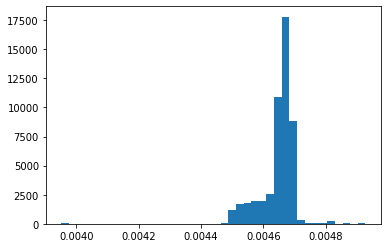

In [62]:
plot.hist(hits_per_photon * 100,bins = 40);
(mu, sigma) = norm.fit(hits_per_photon)
print(f"mean: {mu * 100} | sigma: {sigma * 100}")

## Energy deposited by mu/pi | # of photons per KeV deposited


# photons per KeV = 85356.26420167832 | avg energy dep: 2.338912129198345e-07 | skipped 0 events
mean: 2.338912129198345e-07 | sigma: 4.06011680223071e-07


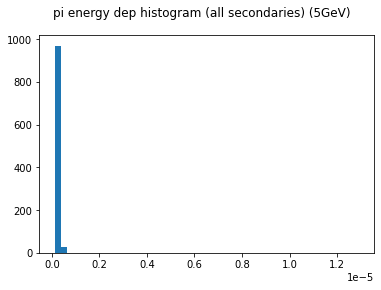

In [9]:
energy_dep_event = []
num_per_kev = []
skipped_events = 0
for event_idx in range(1000):
    num_MC = 0
    num_hits = 0
    dep_count = 0
    energy_dep = 0
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):num_MC+= 1 #count # of optph from muon
    for i in range(len(EDep_branch[event_idx])):
#         if(Hits_MC_idx_branch[event_idx][i] == 0):
        if(True):
            energy_dep += EDep_branch[event_idx][i]
            dep_count += 1
    energy_dep_event.append(energy_dep)
    if(energy_dep == 0):
        skipped_events += 1
        continue
    num_per_kev.append(num_MC / (energy_dep * 1000 * 1000))
print(f"# photons per KeV = {sum(num_per_kev) / len(num_per_kev)} | avg energy dep: {sum(energy_dep_event) / len(energy_dep_event)} | skipped {skipped_events} events")

fig, ax = plot.subplots(1,1)
ax.hist(energy_dep_event,bins= 50);
(mu, sigma) = norm.fit(energy_dep_event)
print(f"mean: {mu} | sigma: {sigma}")
fig.suptitle("pi energy dep histogram (all secondaries) (5GeV)")
fig.show()
# fig.savefig("plots/June_12/energy_dep_pi_all_secondaries.jpeg")

In [ ]:
parent_list = []
for i in range(len(MC_parents[0])):
    if (MC_parents[0][i] not in parent_list):
        parent_list.append(MC_parents[0][i])
for i in range(len(parent_list)):
    print(PDG_branch[0][parent_list[i]])

Plot energy deposition

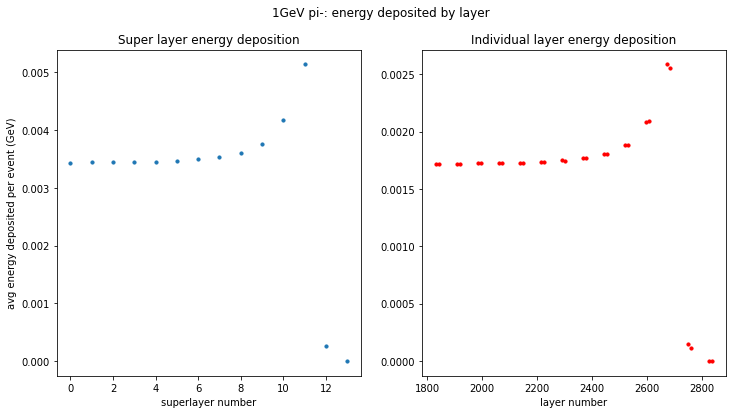

In [78]:
fig,(ax1,ax2) = plot.subplots(1,2,figsize=(12,6))
fig.suptitle("1GeV pi-: energy deposited by layer")
ax1.set_title("Super layer energy deposition")
ax2.set_title("Individual layer energy deposition")

ax1.set_xlabel("superlayer number")
ax2.set_xlabel("layer number")

ax1.set_ylabel("avg energy deposited per event (GeV)")
ax1.scatter(range(14),super_layer_EDep,10)
ax2.scatter(layer_map,layer_EDep,10,color = 'r',marker='o')
fig.show()
# fig.savefig("plots/energy_dep/mu_1GeV_10k_edep_vs_layer_num.jpeg")